# Introduction

Ahhh, my favorite data-set - the auto-mpg data set. So great. Lets train a neural network to solve it!

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer # Imputing isn't always the right choice.
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsRegressor

In [3]:
# Check the version
tf.__version__

'2.3.0'

In [19]:
dataset_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'

In [20]:
column_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin']
raw_df = pd.read_csv(dataset_url, names=column_names, na_values='?', comment='\t', sep=" ", skipinitialspace=True)

In [22]:
raw_df.tail()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [23]:
raw_df.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
model_year        int64
origin            int64
dtype: object

In [116]:
raw_df.shape

(398, 8)

Ah, looks like they've removed the "name" attribute which had some additional interesting features such as the vehicle make and model (though the classes were not well balanced).

In [136]:
df = raw_df.copy(deep=True) # Create a copy of the data that we can manipulate.

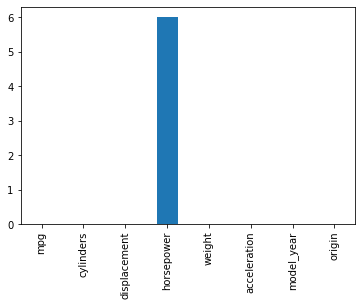

In [118]:
# Check null-values
fig, ax = plt.subplots(figsize=(6,4))
df.isna().sum().plot.bar(ax=ax)

In [119]:
df[df['horsepower'].isna()]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
32,25.0,4,98.0,NaN,2046.0,19.0,71,1
126,21.0,6,200.0,NaN,2875.0,17.0,74,1
330,40.9,4,85.0,NaN,1835.0,17.3,80,2
336,23.6,4,140.0,NaN,2905.0,14.3,80,1
354,34.5,4,100.0,NaN,2320.0,15.8,81,2
374,23.0,4,151.0,NaN,3035.0,20.5,82,1


For funzies, we'll impute with KNN

In [120]:
X_cols = [col for col in df.columns if col != 'horsepower']
y_cols = [col for col in df.columns if col == 'horsepower']

X = df.loc[~df['horsepower'].isna(), X_cols].copy(deep=True)
y = df.loc[~df['horsepower'].isna(), y_cols].copy(deep=True)
imputer = KNeighborsRegressor(n_neighbors=3, algorithm='ball_tree')

In [121]:
imputer.fit(X, y)

KNeighborsRegressor(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                    weights='uniform')

Text(0.5, 1.0, 'Residual')

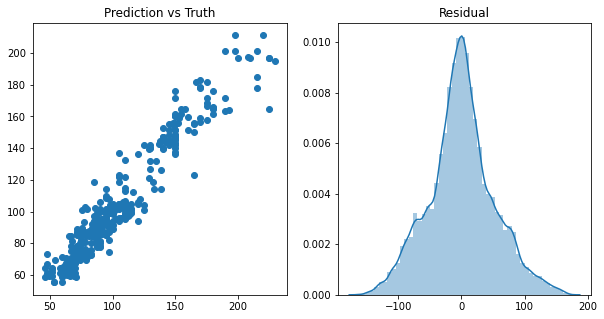

In [122]:
predict = imputer.predict(df[~df['horsepower'].isna()][X_cols])
truth = df[~df['horsepower'].isna()]['horsepower'].values
fig, (ax_1, ax_2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax_1.scatter(truth, predict)
sns.distplot(truth-predict, ax=ax_2)
ax_1.set_title("Prediction vs Truth")
ax_2.set_title("Residual")

Okay, seems like our horsepower residual is a little bit large for my taste- imputing would take more effort than it's worth. Lets drop the NULL values and proceed.

In [137]:
df = df.dropna()
df.shape

(392, 8)

In [124]:
df['origin'].value_counts()

1    245
3     79
2     68
Name: origin, dtype: int64

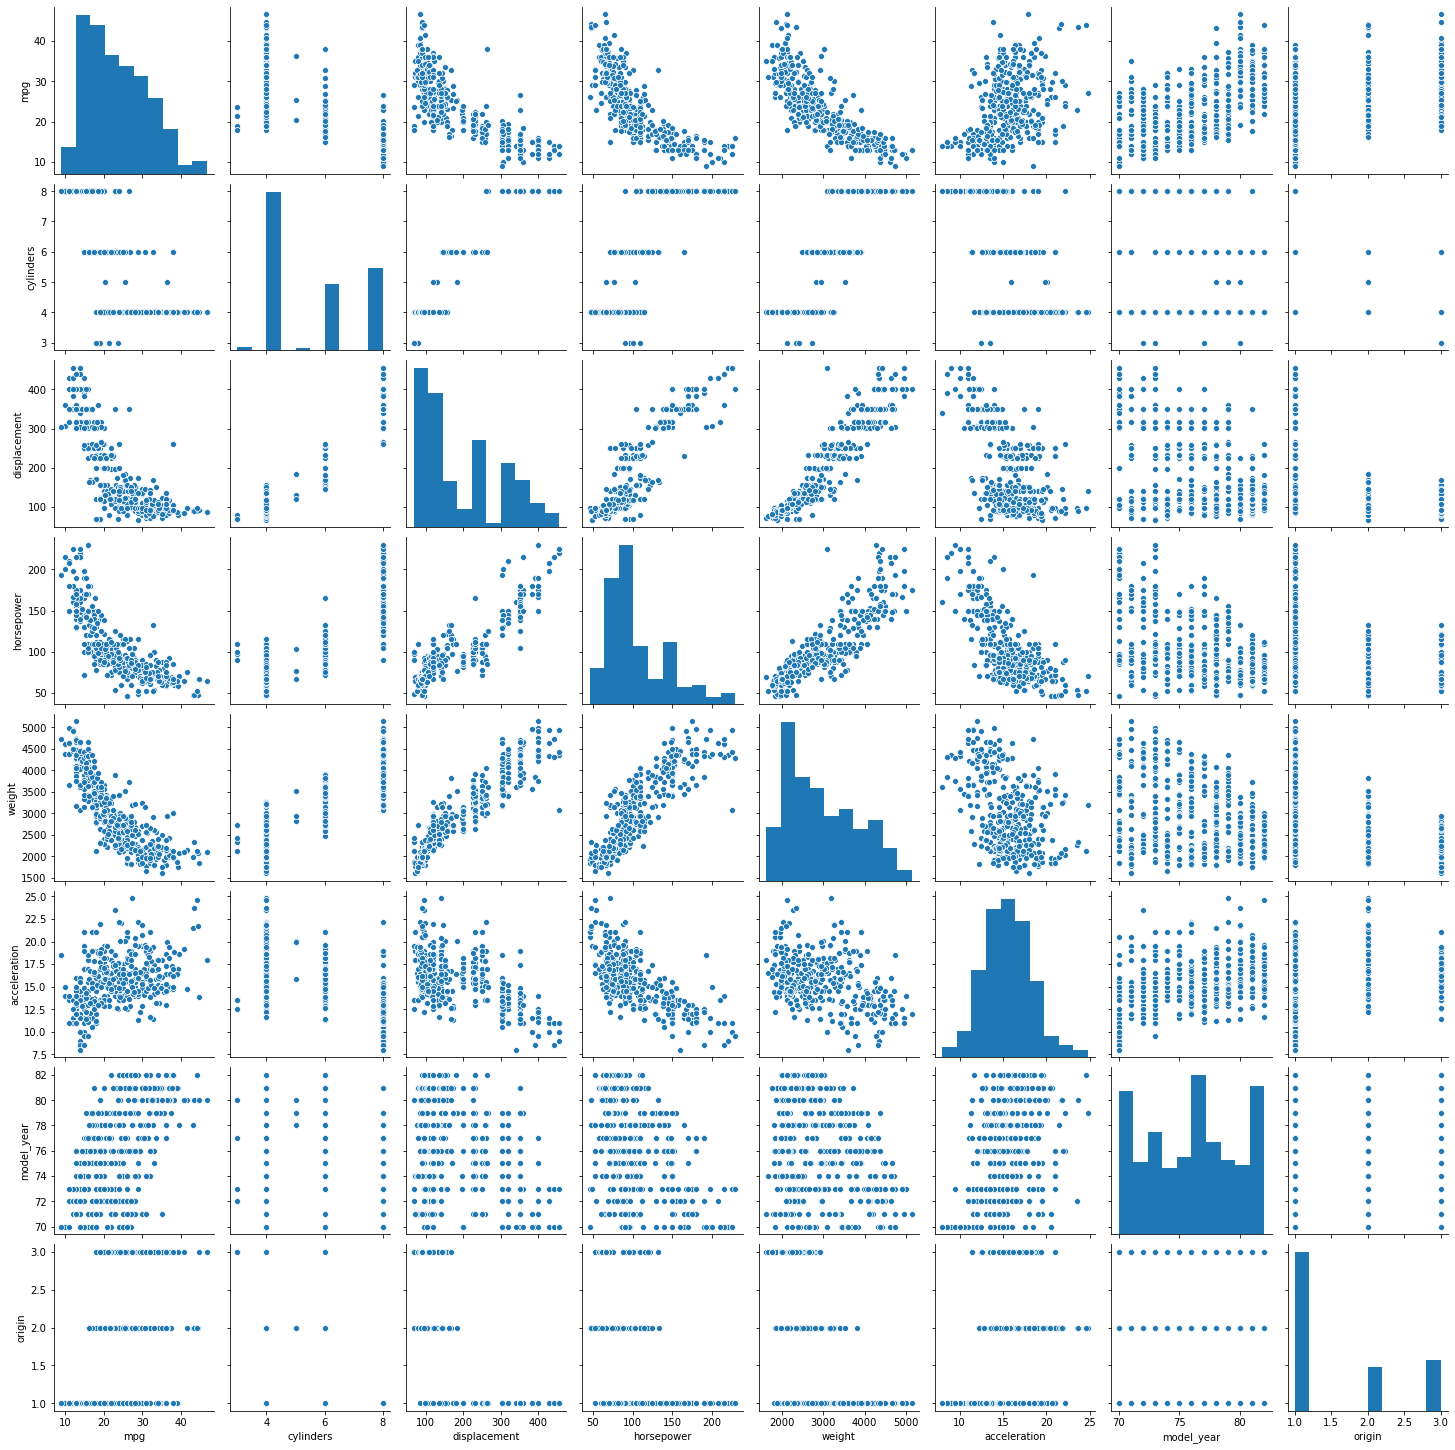

In [125]:
sns.pairplot(df)

Taking a look at the values, it seems like we have a few feature-types.

1. Numeric: `mpg`, `displacement`, `horsepower`, `weight`, `acceleration`
2. Ordinal Numeric: `model_year`, `cylinders`
3. Categorical Numeric: `origin`

Another interesting hot-take - there's a positive correlation between the model year, and the mpg - so I guess all other things equal, cars get more fuel efficient with time. Finally - acceleration seems to be the most 'bell-like' which is kind of interesting - since with the time-component, I'd expect everything to be a bit skewed. However, vehicles seem to be relatively well represented across (ish - there's a few spiky years).

We should probably categorically encode the origin feature - origin `1` happens to correspond to 'USA', origin `2` happens to correspond to 'Europe' and origin `3` corresponds to 'Japan'

In [138]:
df = df.merge(pd.get_dummies(df['origin']).rename(columns={1:'USA', 2:'Europe', 3:'Japan'}), right_index=True, left_index=True)

In [139]:
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,USA,Europe,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,1,0,0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,1,0,0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,1,0,0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,1,0,0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,1,0,0
394,44.0,4,97.0,52.0,2130.0,24.6,82,2,0,1,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,1,0,0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,1,0,0


In [140]:
df.pop('origin')

0      1
1      1
2      1
3      1
4      1
      ..
393    1
394    2
395    1
396    1
397    1
Name: origin, Length: 392, dtype: int64

# Test / Train Split

In [141]:
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

In [142]:
df.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,USA,Europe,Japan
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,0.625000,0.173469,0.201531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.484742,0.379136,0.401656
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,0.000000,0.000000,0.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,0.000000,0.000000,0.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000,0.000000,0.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,1.000000,0.000000,0.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,1.000000,1.000000,1.000000


Note that all of these values have very different ranges.

In [144]:
train_labels = train_dataset.pop('mpg')
test_labels = test_dataset.pop('mpg')

Now, we can normalize our data by using what's basically the 'z-score' - we subtract the mean, and divide by the standard deviation. Note that here, we are using the train stats to normalize both datasets.

In [145]:
def norm(x, stats):
  """
  Summaray statistics stats normalize the dataset X
  Args:
    x: a pandas dataframe containing data
    stats: summary statistics to use to normalize
  """
  return (x - stats['mean']) / stats['std']

In [150]:
stats = train_dataset.describe().T
stats

,count,mean,std,min,25%,50%,75%,max
cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
model_year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [154]:
normed_train = norm(train_dataset, stats)
normed_test = norm(test_dataset, stats)

# Build Model With Keras Sequential

In [164]:
def build_model():
  model = tf.keras.Sequential([
    # Input Layer
    tf.keras.layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.columns)]), # No Flattening needed here.
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(1) # Output layer - no activation function
  ])
  
  model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.RMSprop(0.001),
    metrics=['mae', 'mse']
  )
  
  return model

In [165]:
model = build_model()

In [166]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


Now this is kind of concerning - because we have 4160 parmeters to learn, but only 380 examples of data...hmmm. Lets go ahead and make some batches for prediction to predict using the randomly initialized model.

In [169]:
example_batch = normed_train[:10] # The first 10 examples.
example_result = model.predict(example_batch)
example_result

array([[-0.05262331],
       [ 0.01363865],
       [-0.8048861 ],
       [ 0.09973352],
       [ 0.0418788 ],
       [-0.2063336 ],
       [ 0.04234337],
       [ 0.17051303],
       [-0.19104333],
       [ 0.07030094]], dtype=float32)

This tells us that the model is configured correctly - we expect 10 output predictions that are a floating point integer. Now lets go ahead and train!

In [171]:
# Customize training output.
class PrintProgress(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    print("Finished epoch {}".format(epoch), end='\r')

In [172]:
history = model.fit(normed_train, train_labels, epochs=1000, validation_split=0.2, verbose=0, callbacks=[PrintProgress()]) 

In [191]:
pd.DataFrame(history.history)

,loss,mae,mse,val_loss,val_mae,val_mse
0,574.570374,22.775217,574.570374,566.711670,22.583872,566.711670
1,526.426697,21.706188,526.426697,520.090454,21.535154,520.090454
2,481.817291,20.674934,481.817291,470.125000,20.367605,470.125000
3,433.742188,19.509863,433.742188,416.225830,19.029325,416.225830
4,382.335785,18.175087,382.335785,358.929443,17.514706,358.929443
...,...,...,...,...,...,...
995,2.177062,0.925698,2.177062,12.978048,2.766384,12.978048
996,2.374639,0.968399,2.374639,12.326904,2.699371,12.326904
997,2.077587,0.869735,2.077587,12.424026,2.713778,12.424026
998,2.086537,0.876133,2.086537,12.361407,2.661563,12.361407


Each epoch is a pass through the whole training data set. Lets check the history!

In [206]:
def plot_history(history):
  fig, (ax_1, ax_2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  hist = hist.set_index('epoch')
  hist[['mae', 'val_mae']].rename(columns={'mae':'Train Error - MPG', 'val_mae':'Validation Error - MPG'}).plot(ax=ax_1)
  ax_1.set_ylim([0,5])
  
  plt.figure()
  hist[['mse', 'val_mse']].rename(columns={'mse':'Train Error - $MPG^2$', 'val_mse':'Validation Error - $MPG^2$'}).plot(ax=ax_2)
  ax_2.set_ylim([0,20])
  

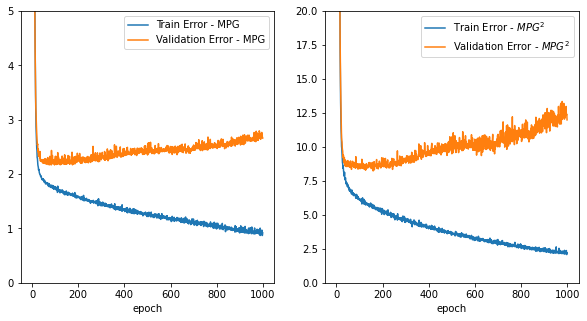

<Figure size 432x288 with 0 Axes>

In [207]:
plot_history(history)

Check it out: the loss and mean absolute error for the validation are increasing with time - this is a classic indication of over-fitting. The model is basically memorizing the dataset.

We can:

1. Reduce the number of parameters
2. Stop the model early (bail when we stop getting improvements)

Lets try early stopping

In [211]:
model_early = build_model()

# Set up early stopping for validation loss
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
early_history = model_early.fit(
  normed_train,
  train_labels,
  epochs=1000,
  validation_split=0.2,
  verbose=0,
  callbacks=[early_stop, PrintProgress()]
)

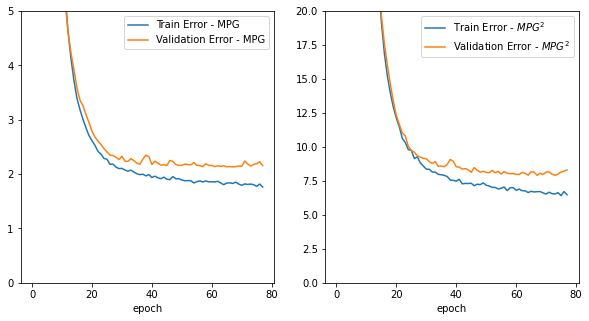

<Figure size 432x288 with 0 Axes>

In [212]:
plot_history(early_history)

OK! Now lets evaluate the model.

In [214]:
loss, mae, mse = model_early.evaluate(normed_test, test_labels, verbose=0)

In [215]:
print("testing set got MAE of {} mpg".format(mae))

testing set got MAE of 1.9392703771591187 mpg


In [216]:
#Try vs linear regression
from sklearn.linear_model import LinearRegression

In [222]:
reg = LinearRegression()
reg.fit(X=normed_train, y=train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [248]:
lin_mae = np.mean(np.fabs(reg.predict(normed_test) - test_labels))
print(lin_mae)

5.121140999216359


Hey - we beat linear regression!

Lets compare.

Text(0.5, 1.0, 'NN - Residual')

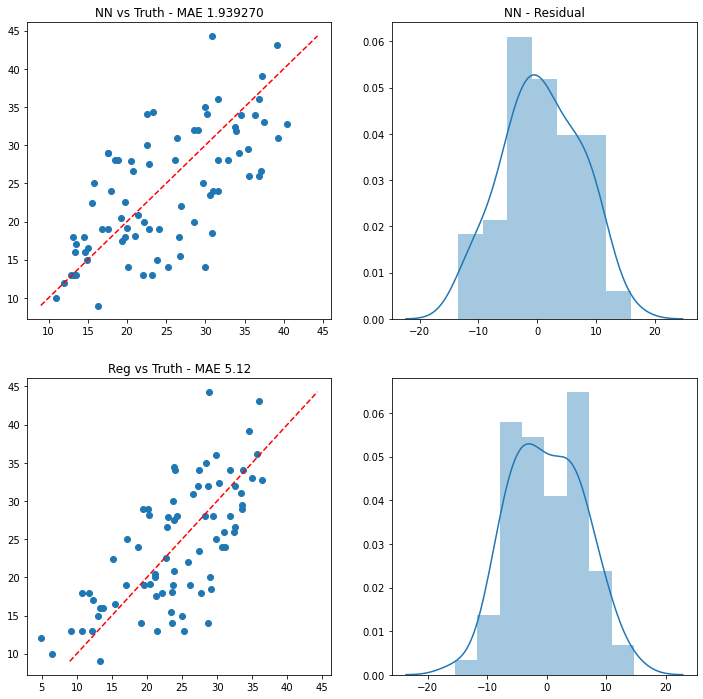

In [249]:
nn_predictions = model_early.predict(normed_test).flatten()
linear_predictions = reg.predict(normed_test).flatten()
true = test_labels.values

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

ax[0,0].scatter(nn_predictions, true)
ax[0,0].plot(sorted(true), sorted(true), color='r', linestyle='--')
ax[0,0].set_title('NN vs Truth - MAE {:2f}'.format(mae))

ax[1,0].scatter(linear_predictions, true)
ax[1,0].plot(sorted(true), sorted(true), color='r', linestyle='--')
ax[1,0].set_title('Reg vs Truth - MAE {:.2f}'.format(lin_mae))

sns.distplot(nn_predictions-true, ax=ax[0,1])
ax[0,1].set_title('NN - Residual')

sns.distplot(linear_predictions-true, ax=ax[1,1])
ax[0,1].set_title('NN - Residual')

